Installing (updating) the following libraries for your Sagemaker
instance.

In [ ]:
!pip install .. # installing d2l


# Redes Residuais (ResNet)
:label:`sec_resnet`

À medida que projetamos redes cada vez mais profundas, torna-se imperativo entender como a adição de camadas pode aumentar a complexidade e a expressividade da rede.
Ainda mais importante é a capacidade de projetar redes onde adicionar camadas torna as redes estritamente mais expressivas, em vez de apenas diferentes.
Para fazer algum progresso, precisamos de um pouco de matemática.


## Classes Função

Considere $\mathcal{F}$, a classe de funções que uma arquitetura de rede específica (junto com as taxas de aprendizado e outras configurações de hiperparâmetros) pode alcançar.
Ou seja, para todos os $f \in \mathcal{F}$ existe algum conjunto de parâmetros (por exemplo, pesos e vieses) que podem ser obtidos através do treinamento em um conjunto de dados adequado.
Vamos supor que $f^*$ seja a função "verdade" que realmente gostaríamos de encontrar.
Se estiver em $\mathcal{F}$, estamos em boa forma, mas normalmente não teremos tanta sorte.
Em vez disso, tentaremos encontrar $f^*_\mathcal{F}$, que é nossa melhor aposta em $\mathcal{F}$.
Por exemplo,
dado um conjunto de dados com recursos $\mathbf{X}$
e rótulos $\mathbf{y}$,
podemos tentar encontrá-lo resolvendo o seguinte problema de otimização:

$$f^*_\mathcal{F} \stackrel{\mathrm{def}}{=} \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \text{ subject to } f \in \mathcal{F}.$$

É razoável supor que, se projetarmos uma arquitetura diferente e mais poderosa $\mathcal{F}'$, chegaremos a um resultado melhor. Em outras palavras, esperaríamos que $f^*_{\mathcal{F}'}$ seja "melhor" do que $f^*_{\mathcal{F}}$. No entanto, se $\mathcal{F} \not\subseteq \mathcal{F}'$ não há garantia de que isso acontecerá. Na verdade, $f^*_{\mathcal{F}'}$ pode muito bem ser pior.
Conforme ilustrado por :numref:`fig_functionclasses`,
para classes de função não aninhadas, uma classe de função maior nem sempre se aproxima da função "verdade" $f^*$. Por exemplo,
à esquerda de: numref: `fig_functionclasses`,
embora$\mathcal{F}_3$ esteja mais perto de  $f^*$ do que $\mathcal{F}_1$, $\mathcal{F}_6$ se afasta e não há garantia de que aumentar ainda mais a complexidade pode reduzir o distância de $f^*$.
Com classes de função aninhadas
onde $\mathcal{F}_1 \subseteq \ldots \subseteq \mathcal{F}_6$
à direita de :numref:`fig_functionclasses`,
podemos evitar o problema mencionado nas classes de função não aninhadas.


![Para classes de função não aninhadas, uma classe de função maior (indicada por área) não garante a aproximação da função "verdade" ($f^*$). Isso não acontece em classes de funções aninhadas.](../img/functionclasses.svg)
:label:`fig_functionclasses`

Por isso,
somente se as classes de função maiores contiverem as menores teremos a garantia de que aumentá-las aumenta estritamente o poder expressivo da rede.
Para redes neurais profundas,
se pudermos
treinar a camada recém-adicionada em uma função de identidade $f(\mathbf{x}) = \mathbf{x}$, o novo modelo será tão eficaz quanto o modelo original. Como o novo modelo pode obter uma solução melhor para se ajustar ao conjunto de dados de treinamento, a camada adicionada pode facilitar a redução de erros de treinamento.

Essa é a pergunta que He et al. considerado quando se trabalha em modelos de visão computacional muito profundos :cite:`He.Zhang.Ren.ea.2016`.
No cerne de sua proposta de *rede residual* (*ResNet*) está a ideia de que cada camada adicional deve
mais facilmente
conter a função de identidade como um de seus elementos.
Essas considerações são bastante profundas, mas levaram a uma soluçao surpreendentemente simples, um *bloco residual*.
Com ele, a ResNet venceu o Desafio de Reconhecimento Visual em Grande Escala da ImageNet em 2015. O design teve uma profunda influência em como
construir redes neurais profundas.



## Blocos Residuais

Vamos nos concentrar em uma parte local de uma rede neural, conforme descrito em :numref:`fig_residual_block`. Denote a entrada por $\mathbf{x}$.
Assumimos que o mapeamento subjacente desejado que queremos obter aprendendo é $f(\mathbf{x})$, a ser usado como entrada para a função de ativação no topo.
À esquerda de :numref:`fig_residual_block`,
a parte dentro da caixa de linha pontilhada
deve aprender diretamente o mapeamento $f(\mathbf{x})$.
A direita,
a parte de dentro da caixa de linha pontilhada
precisa aprender o *mapeamento residual* $f(\mathbf{x}) - \mathbf{x}$,
que é como o bloco residual deriva seu nome.
Se o mapeamento de identidade $f(\mathbf{x}) = \mathbf{x}$ for o mapeamento subjacente desejado,
o mapeamento residual é mais fácil de aprender:
nós só precisamos empurrar os pesos e preconceitos
da
camada de peso superior (por exemplo, camada totalmente conectada e camada convolucional)
dentro da caixa de linha pontilhada
a zero.
A figura certa em :numref:`fig_residual_block` ilustra o *bloco residual* do ResNet,
onde a linha sólida carregando a entrada da camada
$\mathbf{x}$ para o operador de adição
é chamada de *conexão residual* (ou *conexão de atalho*).
Com blocos residuais, as entradas podem
para a frente se propagam mais rápido através das conexões residuais entre as camadas.

![Um bloco regular (esquerda) e um bloco residual (direita).](../img/residual-block.svg)
:label:`fig_residual_block`

ResNet segue o design de camada convolucional  $3\times 3$ completo do VGG. O bloco residual tem duas camadas convolucionais $3\times 3$ com o mesmo número de canais de saída. Cada camada convolucional é seguida por uma camada de normalização em lote e uma função de ativação ReLU. Em seguida, pulamos essas duas operações de convolução e adicionamos a entrada diretamente antes da função de ativação final do ReLU.
Esse tipo de projeto requer que a saída das duas camadas convolucionais tenham o mesmo formato da entrada, para que possam ser somadas. Se quisermos mudar o número de canais, precisamos introduzir uma camada convolucional adicional $1\times 1$ para transformar a entrada na forma desejada para a operação de adição. Vamos dar uma olhada no código abaixo.


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  #@save
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

Este código gera dois tipos de redes: uma onde adicionamos a entrada à saída antes de aplicar a não linearidade ReLU sempre que `use_1x1conv = False`, e outra onde ajustamos os canais e a resolução por meio de uma convolução $1 \times 1$ antes de adicionar.  :numref:`fig_resnet_block` ilustra isso:

![Bloco ResNet com e sem convolução $1 \times 1$.](../img/resnet-block.svg)
:label:`fig_resnet_block`

Agora, vejamos uma situação em que a entrada e a saída têm a mesma forma.


In [2]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

Também temos a opção de reduzir pela metade a altura e largura de saída, aumentando o número de canais de saída.


In [3]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## Modelo ResNet

As duas primeiras camadas do ResNet são iguais às do GoogLeNet que descrevemos antes: a camada convolucional $7\times 7$ com 64 canais de saída e uma passada de 2 é seguida pela camada de pooling máxima $3\times 3$ com uma passada de 2. A diferença é a camada de normalização de lote adicionada após cada camada convolucional no ResNet.


In [4]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet usa quatro módulos compostos de blocos de iniciação.
No entanto, o ResNet usa quatro módulos compostos de blocos residuais, cada um dos quais usa vários blocos residuais com o mesmo número de canais de saída.
O número de canais no primeiro módulo é igual ao número de canais de entrada. Como uma camada de pooling máxima com uma passada de 2 já foi usada, não é necessário reduzir a altura e a largura. No primeiro bloco residual para cada um dos módulos subsequentes, o número de canais é duplicado em comparação com o do módulo anterior e a altura e a largura são reduzidas à metade.

Agora, implementamos este módulo. Observe que o processamento especial foi executado no primeiro módulo.


In [5]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

Em seguida, adicionamos todos os módulos ao ResNet. Aqui, dois blocos residuais são usados para cada módulo.


In [6]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

Finalmente, assim como GoogLeNet, adicionamos uma camada de pooling global média, seguida pela saída da camada totalmente conectada.


In [7]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

Existem 4 camadas convolucionais em cada módulo (excluindo a camada convolucional $1\times 1$). Junto com a primeira camada convolucional $7\times 7$ e a camada final totalmente conectada, há 18 camadas no total. Portanto, esse modelo é comumente conhecido como ResNet-18.
Configurando diferentes números de canais e blocos residuais no módulo, podemos criar diferentes modelos de ResNet, como o ResNet-152 de 152 camadas mais profundo. Embora a arquitetura principal do ResNet seja semelhante à do GoogLeNet, a estrutura do ResNet é mais simples e fácil de modificar. Todos esses fatores resultaram no uso rápido e generalizado da ResNet. :numref:`fig_resnet18` representa o ResNet-18 completo.

![A arquiteturaResNet-18.](../img/resnet18.svg)
:label:`fig_resnet18`

Antes de treinar o ResNet, vamos observar como a forma da entrada muda nos diferentes módulos do ResNet. Como em todas as arquiteturas anteriores, a resolução diminui enquanto o número de canais aumenta até o ponto em que uma camada de pooling média global agrega todos os recursos.


In [8]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


## Treinamento

Treinamos ResNet no conjunto de dados Fashion-MNIST, assim como antes.


loss 0.014, train acc 0.997, test acc 0.861
4691.0 examples/sec on cuda:0


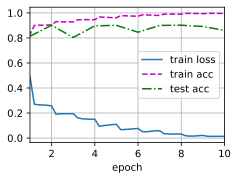

In [9]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## Sumário

* As classes de funções aninhadas são desejáveis. Aprender uma camada adicional em redes neurais profundas como uma função de identidade (embora este seja um caso extremo) deve ser facilitado.
* O mapeamento residual pode aprender a função de identidade mais facilmente, como empurrar parâmetros na camada de peso para zero.
* Podemos treinar uma rede neural profunda eficaz tendo blocos residuais. As entradas podem se propagar para frente mais rápido através das conexões residuais entre as camadas.
* O ResNet teve uma grande influência no projeto de redes neurais profundas subsequentes, tanto de natureza convolucional quanto sequencial.


## Exercícios

1. Quais são as principais diferenças entre o bloco de iniciação em :numref:`fig_inception` e o bloco residual? Depois de remover alguns caminhos no bloco de *Inception*, como eles se relacionam?
1. Consulte a Tabela 1 no artigo ResNet :cite:`He.Zhang.Ren.ea.2016` para
    implementar variantes diferentes.
1. Para redes mais profundas, a ResNet apresenta uma arquitetura de "gargalo" para reduzir
    complexidade do modelo. Tente implementá-lo.
1. Nas versões subsequentes do ResNet, os autores alteraram a configuração "convolução, lote
    normalização e ativação "estrutura para a" normalização em lote,
    estrutura de ativação e convolução ". Faça esta melhoria
    você mesmo. Veja a Figura 1 em :cite:`He.Zhang.Ren.ea.2016 * 1`
    para detalhes.
1. Por que não podemos simplesmente aumentar a complexidade das funções sem limites, mesmo se as classes de função estiverem aninhadas?


[Discussions](https://discuss.d2l.ai/t/86)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTE5MzU3MDYyNDIsOTI5NTMwNTkxLC0xOT
I2NDYyOTI0LC05Mzc1MzI2NDYsMTQzNDAzMTEyNSwzNzc1ODU1
NDNdfQ==
-->
